In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
import string 
import spacy 
from spacy.lang.pt.stop_words import STOP_WORDS
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm 
from sklearn.metrics.pairwise import cosine_distances,cosine_similarity

In [2]:
import openai 
from openai import OpenAI

In [3]:
import openai
from openai import OpenAI
apinumber='sua chave aqui'
openai.api_key = apinumber
client = OpenAI(api_key=apinumber)

In [4]:
models = client.models.list()

In [5]:
for i in range(len(models.data)):
    print(models.data[i].id)

gpt-4-0613
gpt-4
gpt-3.5-turbo
gpt-4-0314
o3-pro-2025-06-10
codex-mini-latest
o3-pro
gpt-4o-realtime-preview-2025-06-03
gpt-4o-audio-preview-2025-06-03
davinci-002
babbage-002
gpt-3.5-turbo-instruct
gpt-3.5-turbo-instruct-0914
dall-e-3
dall-e-2
gpt-4-1106-preview
gpt-3.5-turbo-1106
tts-1-hd
tts-1-1106
tts-1-hd-1106
text-embedding-3-small
text-embedding-3-large
gpt-4-0125-preview
gpt-4-turbo-preview
gpt-3.5-turbo-0125
gpt-4-turbo
gpt-4-turbo-2024-04-09
gpt-4o
gpt-4o-2024-05-13
gpt-4o-mini-2024-07-18
gpt-4o-mini
gpt-4o-2024-08-06
chatgpt-4o-latest
o1-preview-2024-09-12
o1-preview
o1-mini-2024-09-12
o1-mini
gpt-4o-realtime-preview-2024-10-01
gpt-4o-audio-preview-2024-10-01
gpt-4o-audio-preview
gpt-4o-realtime-preview
omni-moderation-latest
omni-moderation-2024-09-26
gpt-4o-realtime-preview-2024-12-17
gpt-4o-audio-preview-2024-12-17
gpt-4o-mini-realtime-preview-2024-12-17
gpt-4o-mini-audio-preview-2024-12-17
o1-2024-12-17
o1
gpt-4o-mini-realtime-preview
gpt-4o-mini-audio-preview
computer-u

In [6]:
sentimento=pd.read_csv('sentimento_ingles.csv')
sentimento

,id,text,label
0,219,Enjoy 0% instalment for up to 12 months when o...,neutral
1,209,The cakes give me massive nostalgia. Everythin...,positive
2,436,Mom once worked for grab indonesia.,neutral
3,394,"I love having lunch here the most, thanks to t...",positive
4,592,The DAMRI Bus service is really good,positive
...,...,...,...
495,589,A talks like empty vessels that make the most ...,negative
496,636,You won't find this sambal anywhere else. The ...,positive
497,710,"I think the steak was quite good, my advice is...",positive
498,250,"Watch what you eat, Gus, it's that kind of sea...",negative


In [7]:
sentimento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      500 non-null    int64 
 1   text    500 non-null    object
 2   label   500 non-null    object
dtypes: int64(1), object(2)
memory usage: 11.8+ KB


In [8]:
sentimento.text.iloc[0]

'Enjoy 0% instalment for up to 12 months when ordering an Air Asia plane ticket with BNI Credit Card!'

In [9]:
sentimento.text.iloc[1]

"The cakes give me massive nostalgia. Everything is old school. from the presentation to the taste. They're great and inexpensive"

In [10]:
sentimento.label.iloc[0]

'neutral'

In [11]:
sentimento.label.iloc[1]

'positive'

In [12]:
sentimento['label'].value_counts()

negative    192
positive    189
neutral     119
Name: label, dtype: int64

In [13]:
sent_treinamento=sentimento[0:400].reset_index(drop=True)
sent_validacao=sentimento[400:].reset_index(drop=True)

In [14]:
def gerador_de_resposta_3p5(texto):
    
    texto_promt=f"""Eu quero que você classifique o texto abaixo como "POSITIVO", "NEGATIVO" ou "NEUTRO". 
    Apenas responda os textos com "POSITIVO", "NEGATIVO" ou "NEUTRO". 

    O texto que quero que você avalie é: 

    "{texto}"

    Eu quero respostas diretas. Não há necessidade de explicações. Apenas o valor da classificação."""
    
   
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",        
        messages=[
            {"role": "user", "content": texto_promt}],
        n=1,temperature=0.0
    )
    return response.choices[0].message.content

In [15]:
def gerador_de_resposta_4o(texto):
    
    texto_promt=f"""Eu quero que você classifique o texto abaixo como "POSITIVO", "NEGATIVO" ou "NEUTRO". 
    Apenas responda os textos com "POSITIVO", "NEGATIVO" ou "NEUTRO". 

    O texto que quero que você avalie é: 

    "{texto}"

    Eu quero respostas diretas. Não há necessidade de explicações. Apenas o valor da classificação."""
    
   
    response = client.chat.completions.create(
        model="gpt-4o",        
        messages=[
            {"role": "user", "content": texto_promt}],
        n=1,temperature=0.0
    )
    return response.choices[0].message.content

In [16]:
gerador_de_resposta_3p5("Eu amo o Lula")

'POSITIVO'

In [17]:
gerador_de_resposta_3p5("Eu odeio o Lula")

'NEGATIVO'

In [18]:
respostagpt3p5=[]
respostagpt4o=[]
for i in tqdm(range(len(sent_validacao))):
    texto=sent_validacao.text.iloc[i]
    
    respostagpt3p5.append(gerador_de_resposta_3p5(texto))
    respostagpt4o.append(gerador_de_resposta_4o(texto))

100%|██████████| 100/100 [02:38<00:00,  1.59s/it]


In [19]:
GPT=pd.DataFrame({"REAL":sent_validacao.label.values,
                 "GPT_3p5":respostagpt3p5,
                 "GPT_4o":respostagpt4o})
GPT

,REAL,GPT_3p5,GPT_4o
0,positive,POSITIVO,POSITIVO
1,negative,NEGATIVO,NEGATIVO
2,neutral,POSITIVO,NEUTRO
3,negative,NEUTRO,NEUTRO
4,negative,NEGATIVO,NEGATIVO
...,...,...,...
95,negative,NEGATIVO,NEGATIVO
96,positive,POSITIVO,POSITIVO
97,positive,POSITIVO,POSITIVO
98,negative,NEUTRO,NEGATIVO


In [20]:
GPT.GPT_3p5.value_counts()

POSITIVO    44
NEGATIVO    44
NEUTRO      12
Name: GPT_3p5, dtype: int64

In [21]:
GPT.GPT_4o.value_counts()

NEGATIVO    42
POSITIVO    37
NEUTRO      21
Name: GPT_4o, dtype: int64

In [22]:
def modifica_label(x):
    if x=="NEGATIVO":
        return "negative"
    if x=="POSITIVO":
        return "positive"
    if x=="NEUTRO":
        return "neutral"

In [23]:
GPT["GPT_3p5"]=GPT["GPT_3p5"].apply(modifica_label)
GPT["GPT_4o"]=GPT["GPT_4o"].apply(modifica_label)

In [24]:
GPT

,REAL,GPT_3p5,GPT_4o
0,positive,positive,positive
1,negative,negative,negative
2,neutral,positive,neutral
3,negative,neutral,neutral
4,negative,negative,negative
...,...,...,...
95,negative,negative,negative
96,positive,positive,positive
97,positive,positive,positive
98,negative,neutral,negative


In [25]:
acuracia_3p5=accuracy_score(GPT["REAL"],GPT["GPT_3p5"])
print('ACURACIA',acuracia_3p5)

ACURACIA 0.86


In [26]:
acuracia_4o=accuracy_score(GPT["REAL"],GPT["GPT_4o"])
print('ACURACIA',acuracia_4o)

ACURACIA 0.91


Text(137.16666666666669, 0.5, 'real')

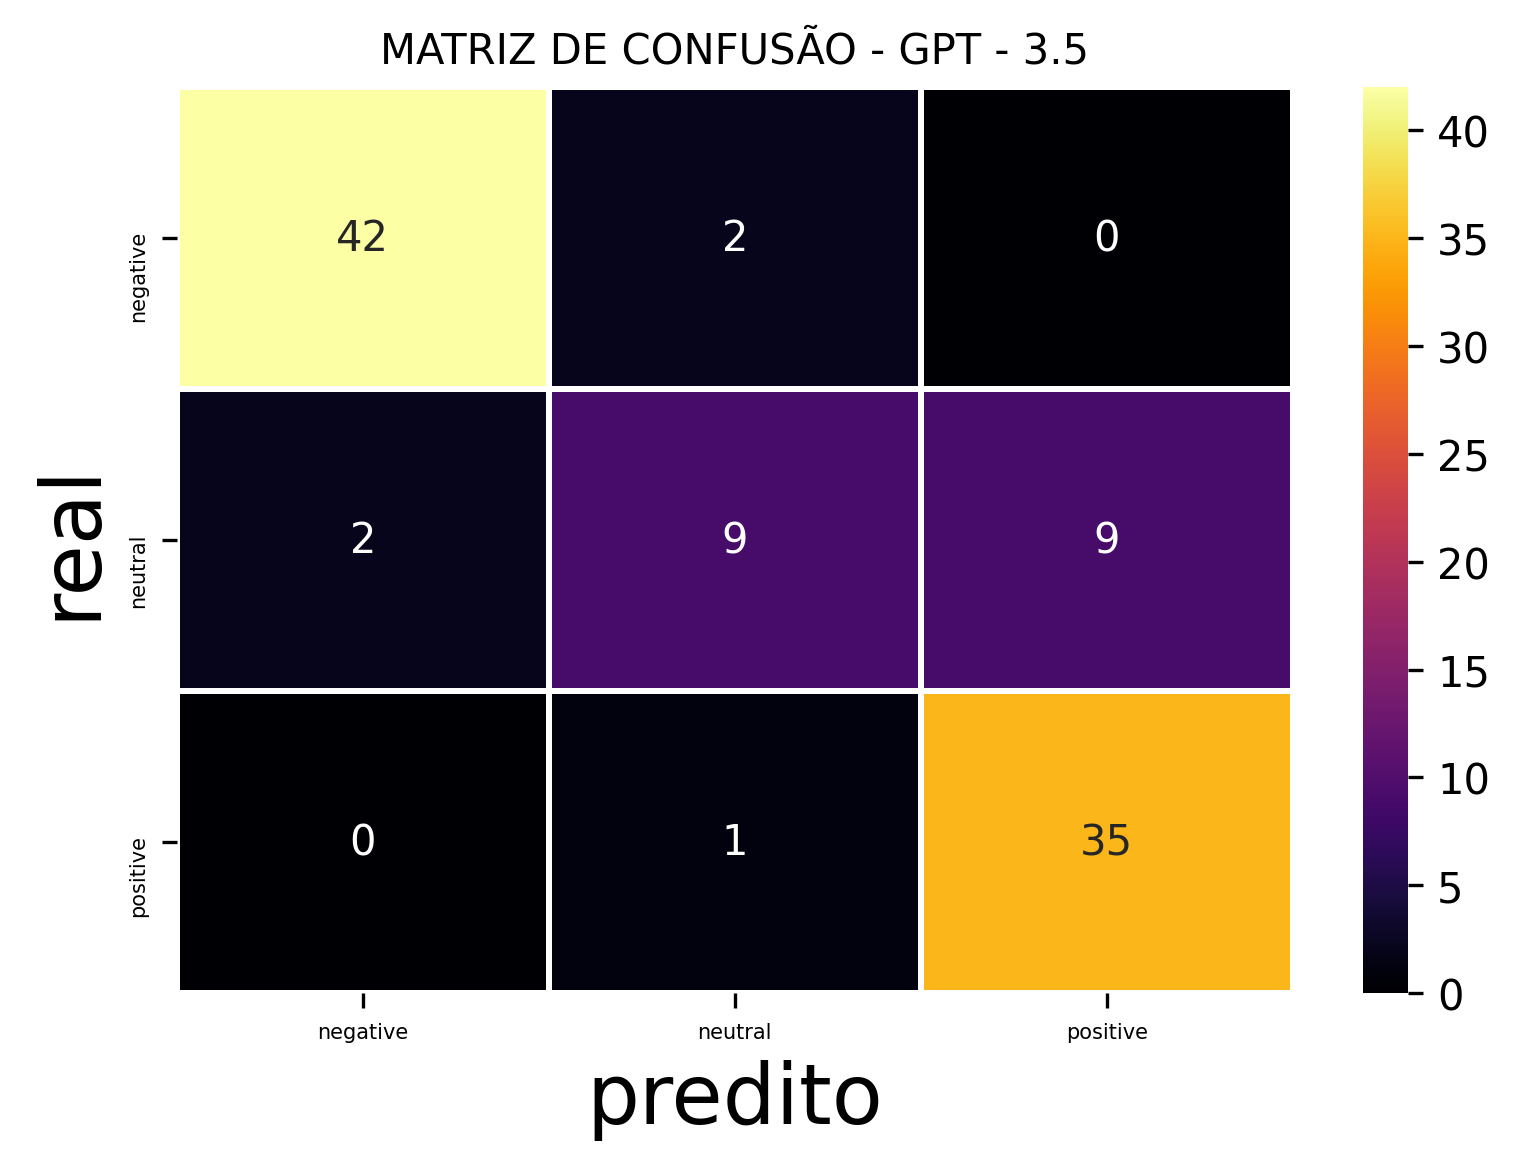

In [27]:
plt.figure(dpi=300)
plt.title('MATRIZ DE CONFUSÃO - GPT - 3.5',fontsize=10)
sns.heatmap(confusion_matrix(GPT["REAL"],GPT["GPT_3p5"]),annot=True,cmap='inferno',lw=1,annot_kws={"size":10})
plt.xticks([0.5,1.5,2.5],['negative','neutral','positive'],fontsize=5)
plt.yticks([0.5,1.5,2.5],['negative','neutral','positive'],fontsize=5)
plt.xlabel('predito',fontsize=20)
plt.ylabel('real',fontsize=20)

Text(137.16666666666669, 0.5, 'real')

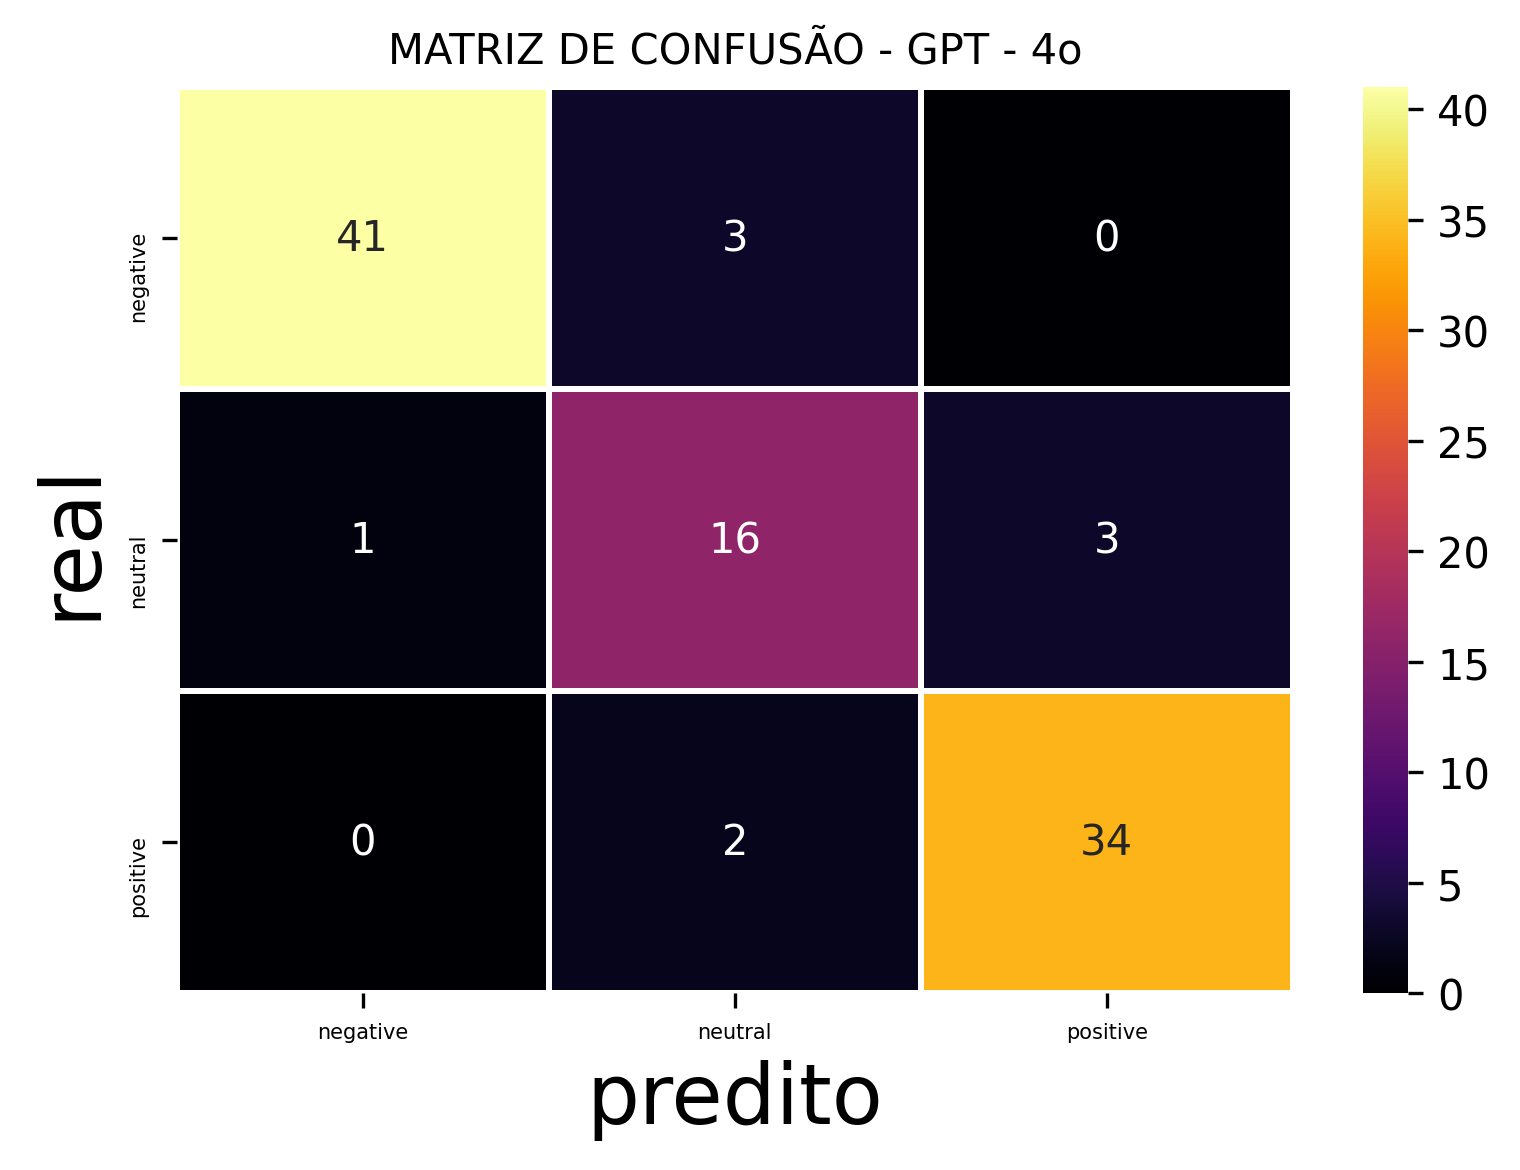

In [28]:
plt.figure(dpi=300)
plt.title('MATRIZ DE CONFUSÃO - GPT - 4o',fontsize=10)
sns.heatmap(confusion_matrix(GPT["REAL"],GPT["GPT_4o"]),annot=True,cmap='inferno',lw=1,annot_kws={"size":10})
plt.xticks([0.5,1.5,2.5],['negative','neutral','positive'],fontsize=5)
plt.yticks([0.5,1.5,2.5],['negative','neutral','positive'],fontsize=5)
plt.xlabel('predito',fontsize=20)
plt.ylabel('real',fontsize=20)